In [1]:
import pygplates
import pandas as pd
import numpy as np
import geopandas as gpd

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(pygplates.__version__)

from gprm import ReconstructionModel, SubductionConvergence, PointDistributionOnSphere
from gprm.datasets import Reconstructions, Seafloor
from gprm.utils.create_gpml import gdf2gpml, gpml2gdf


0.36.0


In [2]:
M2019 = Reconstructions.fetch_Muller2019()


/Users/Simon/GIT/PlateTectonicTools/ptt/subduction_convergence.py:313: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Challenger Plateau NE margin" at 100.0Ma.
    Either the subduction polarity is not properly set or there are too many subducting plates sharing the sub-segment.
    Ignoring current sub-segment.
  warnings.warn(
/Users/Simon/GIT/PlateTectonicTools/ptt/subduction_convergence.py:313: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Trench during period Laramide Flat Slab" at 100.0Ma.
    Either the subduction polarity is not properly set or there are too many subducting plates sharing the sub-segment.
    Ignoring current sub-segment.
  warnings.warn(


<Figure size 864x360 with 0 Axes>

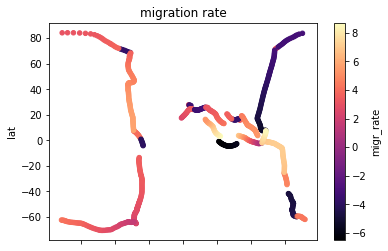

In [3]:
# compute the subduction zone kinematics for a single time snapshot
# results are returned in a 'SubductionConvergence' class object

reconstruction_time = 100.

subduction_kinematics = SubductionConvergence(M2019, reconstruction_time, threshold_sampling_distance_radians=0.02)

mr = np.asarray(subduction_kinematics.df['migr_rate'], dtype=np.float64)
mo = np.asarray(subduction_kinematics.df['migr_obliq'], dtype=np.float64)

subduction_kinematics.df['ortho_migr_rate'] = pd.Series(mr*np.sin(np.radians(np.abs(mo))), index=subduction_kinematics.df.index)

subduction_kinematics.plot('mr')

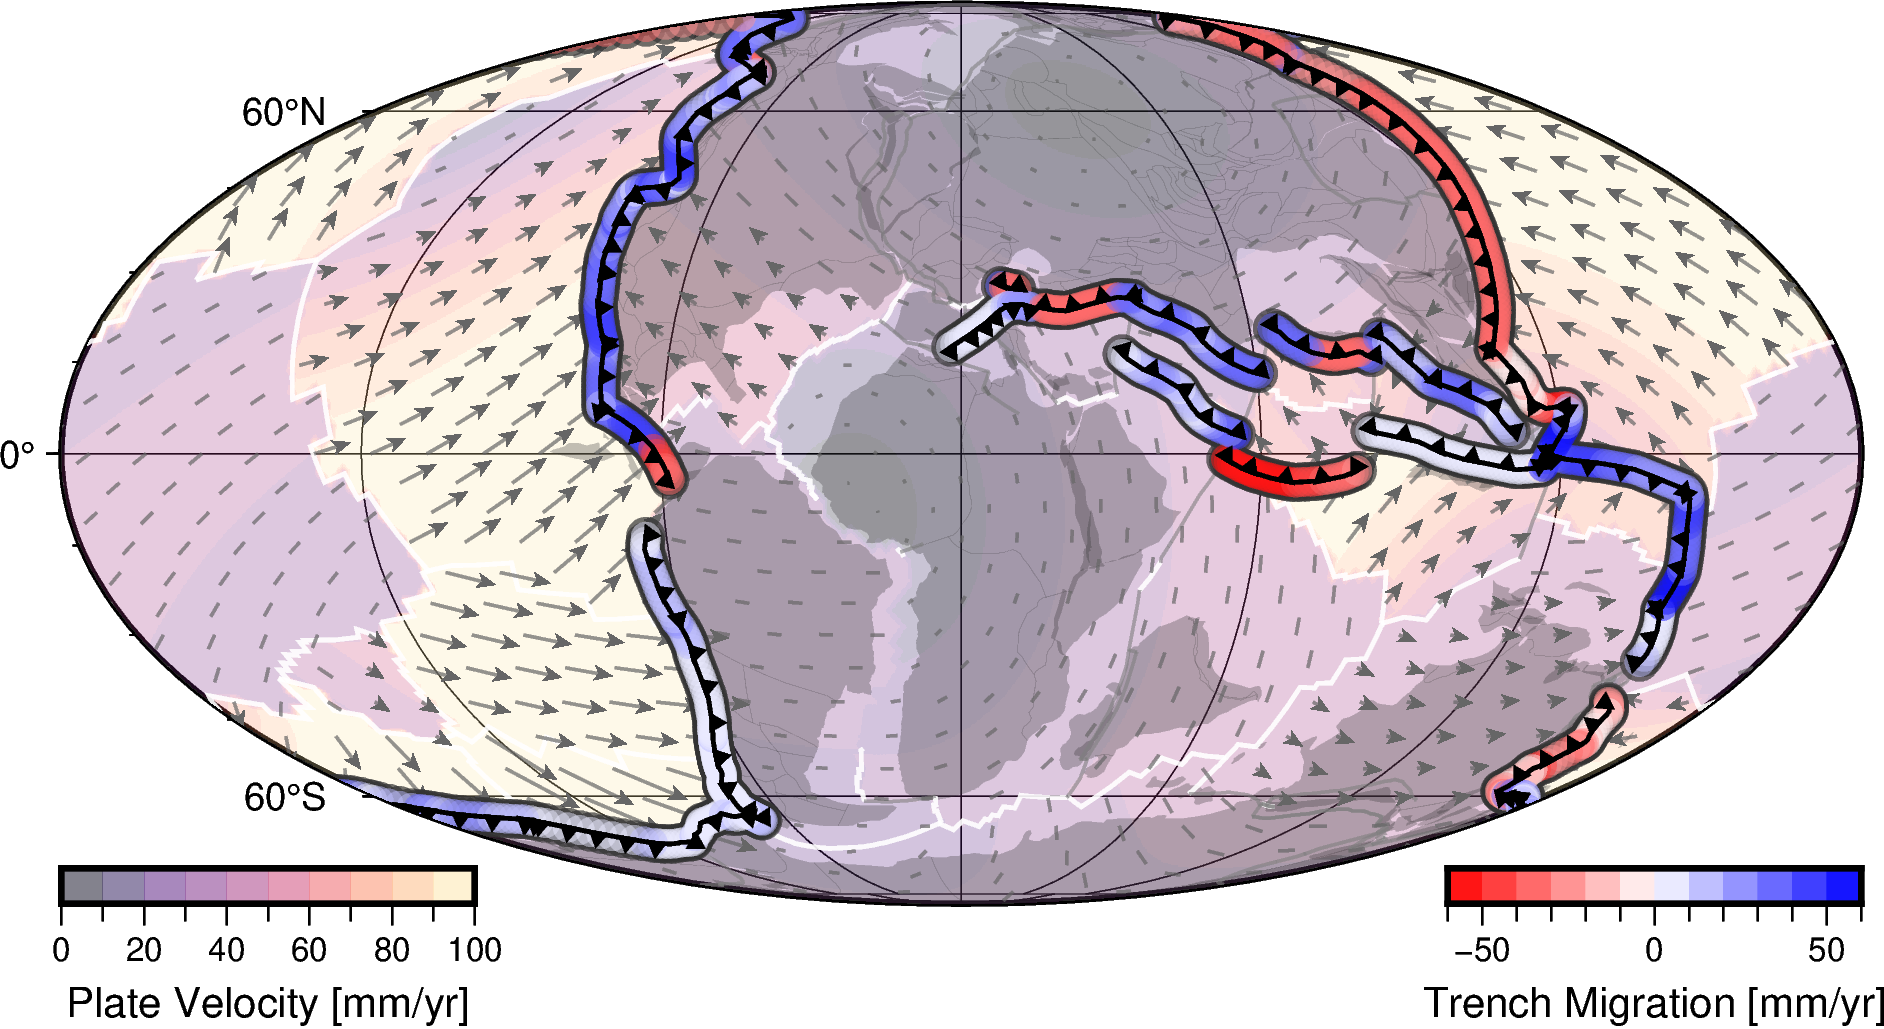

In [4]:
#psxy -R$frame -J$proj -m -W0.08p,firebrick tmpAA.xy -SV0.00025c/0.06c/0.03c -Gfirebrick -f0x,1y,8f,6f -O -K -V >> $outfile1
#psxy -R$frame -J$proj -m -W0.08p,steelblue tmpRR.xy -SV0.00025c/0.06c/0.03c -Gsteelblue -f0x,1y,8f,6f -O -K -V >> $outfile1
import pygmt

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)


velocity_domain = PointDistributionOnSphere(distribution_type='healpix', N=32)
velocity_field = reconstructed_plates.velocity_field(velocity_domain_features=[velocity_domain.meshnode_feature])
velgrd = velocity_field.to_grid(spacing='0.25d')

velocity_domain = PointDistributionOnSphere(distribution_type='healpix', N=8)
velocity_field = reconstructed_plates.velocity_field(velocity_domain_features=[velocity_domain.meshnode_feature])


scaling=10
tmp = np.vstack((subduction_kinematics.df.lon,
                 subduction_kinematics.df.lat,
                 subduction_kinematics.df.arc_azimuth+180,
                 subduction_kinematics.df.ortho_migr_rate/scaling)).T

fig = pygmt.Figure()
fig.basemap(region='d', projection='W6i', frame='afg')

pygmt.makecpt(cmap='magma', series=[0,100,10], background='o', reverse=False, transparency=50)
fig.grdimage(grid=velgrd, cmap=True, transparency=75)

M2019.polygon_snapshot('continents', reconstruction_time).plot(fig, transparency=70, pen=None, color='gray20')

reconstructed_plates.plot_mid_ocean_ridges(fig, pen='1p,white', transparency=10)
reconstructed_plates.plot_other_boundaries(fig, pen='0.7p,gray50', transparency=40)

velocity_field.plot(fig, scaling=300., pen="0.7p,gray40", color='gray40',
                    style='V0.15c+e+a45+ggray40', transparency=30)

with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='10p'):
    fig.colorbar(position='JBL+jBL+o0.0c+w3.5c/0.3c+h', transparency=20, frame=['x+lPlate Velocity [mm/yr]'])#, box='+gwhite+p0.5p')


#scaling = 300
#tmp = np.vstack((velocity_field.longitude,
#                 velocity_field.latitude,
#                 np.degrees(velocity_field.velocity_azimuth),
#                 np.array(velocity_field.velocity_magnitude)/scaling)).T
#pygmt.makecpt(cmap='polar', series=[0,100,1], background='o', reverse=False)
#fig.plot(data=tmp, pen="0.5p", zvalue=np.array(velocity_field.velocity_magnitude)*10.,
#            cmap=True, style='V0.15c+e+a45')

fig.plot(x=subduction_kinematics.df.lon,
         y=subduction_kinematics.df.lat,
         style='c0.33c', color='gray20', transparency=30)

pygmt.makecpt(cmap='polar', series=[-60,60,10], background='o', reverse=True)
fig.plot(x=subduction_kinematics.df.lon,
         y=subduction_kinematics.df.lat,
         color=subduction_kinematics.df.ortho_migr_rate*10,
         style='c0.25c', cmap=True, transparency=50)
with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='10p'):
    fig.colorbar(position='JBR+jBR+o0.0c+w3.5c/0.3c+h', frame=['x+lTrench Migration [mm/yr]'])#, box='+gwhite+p0.5p')


reconstructed_plates.plot_subduction_zones(fig, pen='1p,black', gap=8, size=3)
#reconstructed_plates.plot_deformation_zones(fig, perspective=perspective)

#style='V0.1c+e'
#fig.plot(data=tmp[::4,:], style=style, pen='1p,blue')


#tree_object = M2019.platetree()
#tree_object.plot_gmt(fig, reconstruction_time, polygons='dynamic', link_pen='1p,gray10')

fig.savefig('./figures/optimization.eps')
fig.show(width=1000)



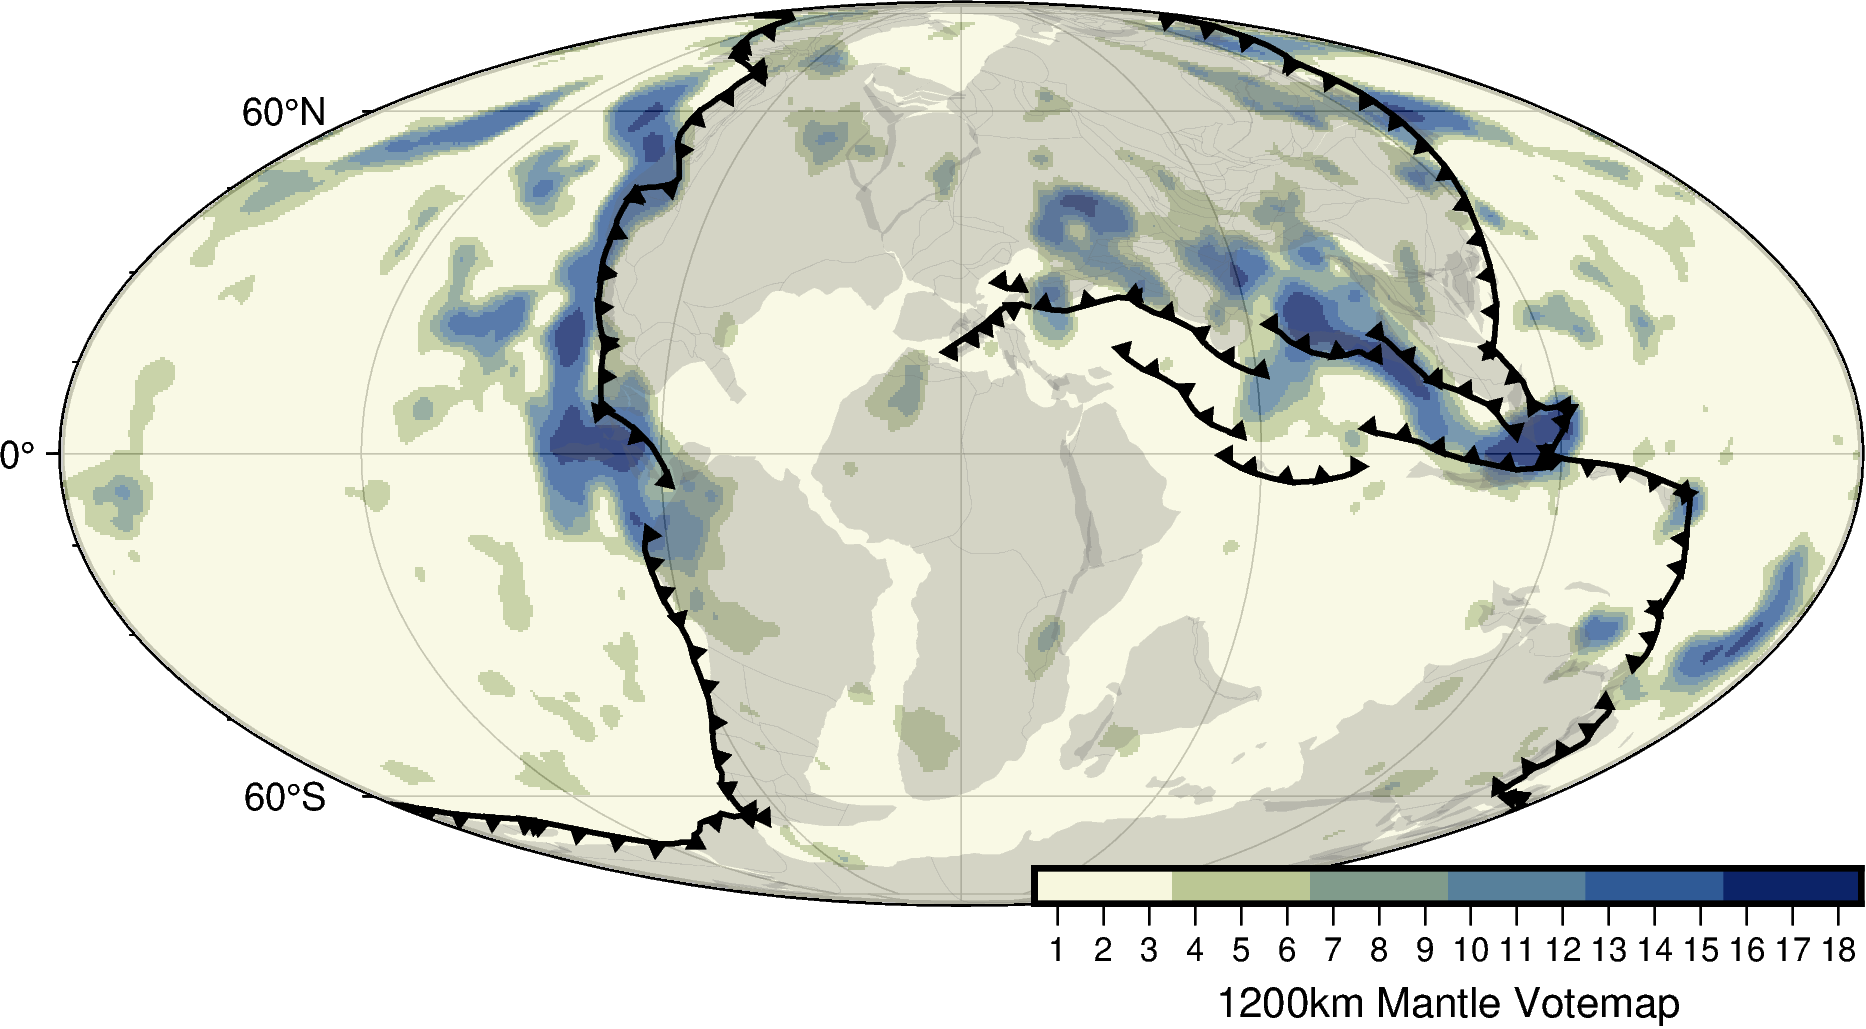

In [29]:
M2019 = Reconstructions.fetch_Muller2019()

LIPs = Seafloor.LargeIgneousProvinces()



reconstruction_time = 100.

votemap = pygmt.xyz2grd('/Users/simon/Data/SeismicTomography/votemaps/SubMachine_votemap_depth_slice_1200.txt',
                        region='d', spacing='0.5d')
votemap_filt = pygmt.grdfilter(grid=votemap, distance=2, filter='g500', coltypes='g')

fig = pygmt.Figure()
fig.basemap(region='d', projection='W6i', frame='afg')

#lekic_filt = pygmt.grdfilter(grid='/Users/simon/Work/DynamicTopography/Clustering_Lekic.nc', distance=2, filter='g1000', spacing='0.5d')
#pygmt.makecpt(cmap='bilbao', series=[0,6,1], background=False)
#fig.grdimage(grid=lekic_filt, cmap=True, transparency=0, interpolation='l')

#pygmt.makecpt(cmap='white,210/240/210,darkseagreen,steelblue,darkslateblue,navyblue', series=[0,18,3], background='o')
pygmt.makecpt(cmap='SCM/davos', series=[0.5,18.5,3], background='o',reverse=True)
fig.grdimage(grid=votemap_filt, cmap=True, transparency=20)


M2019.polygon_snapshot('continents', reconstruction_time).plot(fig, transparency=75, pen=None, color='gray40')

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_plates.plot_subduction_zones(fig, pen='1.2p,black', gap=9, size=3)

with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='10p'):
    fig.colorbar(position='JBR+jBR+o0.0c+w7.0c/0.3c+h', frame=['xa1+l1200km Mantle Votemap'])

fig.savefig('./figures/slab_fitting.png')
fig.show(width=1000)


In [ ]:
LIPs = gdf2gpml(Seafloor.LargeIgneousProvinces())


LIP_centroids = []
for feature in LIPs:
    if feature.get_geometry():
        LIP_centroid = pygplates.Feature()
        LIP_centroid.set_geometry(feature.get_geometry().get_interior_centroid())
        LIP_centroid.set_reconstruction_plate_id(feature.get_reconstruction_plate_id())
        LIP_centroid.set_valid_time(feature.get_valid_time()[0], feature.get_valid_time()[1])
        LIP_centroid.set_name(feature.get_name())
        LIP_centroids.append(LIP_centroid)

LIP_centroids = pygplates.FeatureCollection(LIP_centroids)



def reconstructed_volcanics(reconstruction_model, reconstruction_time, time_range, anchor_plate_id=0):

    time_min = reconstruction_time-time_range
    time_max = reconstruction_time+time_range

    LIP_centroids = []
    for feature in LIPs:
        if feature.get_valid_time()[0]>time_min and feature.get_valid_time()[0]<time_max:
            if feature.get_geometry():
                #print(feature.get_geometry().get_boundary_centroid())
                LIP_centroid = pygplates.Feature()
                LIP_centroid.set_geometry(feature.get_geometry().get_boundary_centroid())
                LIP_centroid.set_reconstruction_plate_id(feature.get_reconstruction_plate_id())
                LIP_centroid.set_valid_time(time_max, time_min)
                LIP_centroid.set_name(feature.get_name())
                LIP_centroids.append(LIP_centroid)

    reconstructed_centroids = reconstruction_model.reconstruct(pygplates.FeatureCollection(LIP_centroids),
                                                               reconstruction_time)

    return gpml2gdf(reconstructed_centroids)          

In [7]:
HS = pd.read_excel('./data/1810-1_JacksonD_et_al_2020.xlsx', sheet_name='Table S1', skiprows=1, header=None)

header_rows = HS.iloc[0:4,:].replace({np.nan: ''})
header_rows = header_rows.astype('str')
header_str = [' '.join(header_rows.iloc[:,i].tolist()) for i in header_rows.columns]
header_str = [s.strip() for s in header_str]

HS.columns = header_str

HS = HS.iloc[5:,:]

HS = HS.replace({'Tasmandit': 'Tasmantid'}, regex=True)

HS = HS.dropna(subset=['Hotspot Longitude (at surface) Vertical plume'])


/opt/anaconda3/envs/pygmt6/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
/opt/anaconda3/envs/pygmt6/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/anaconda3/envs/pygmt6/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


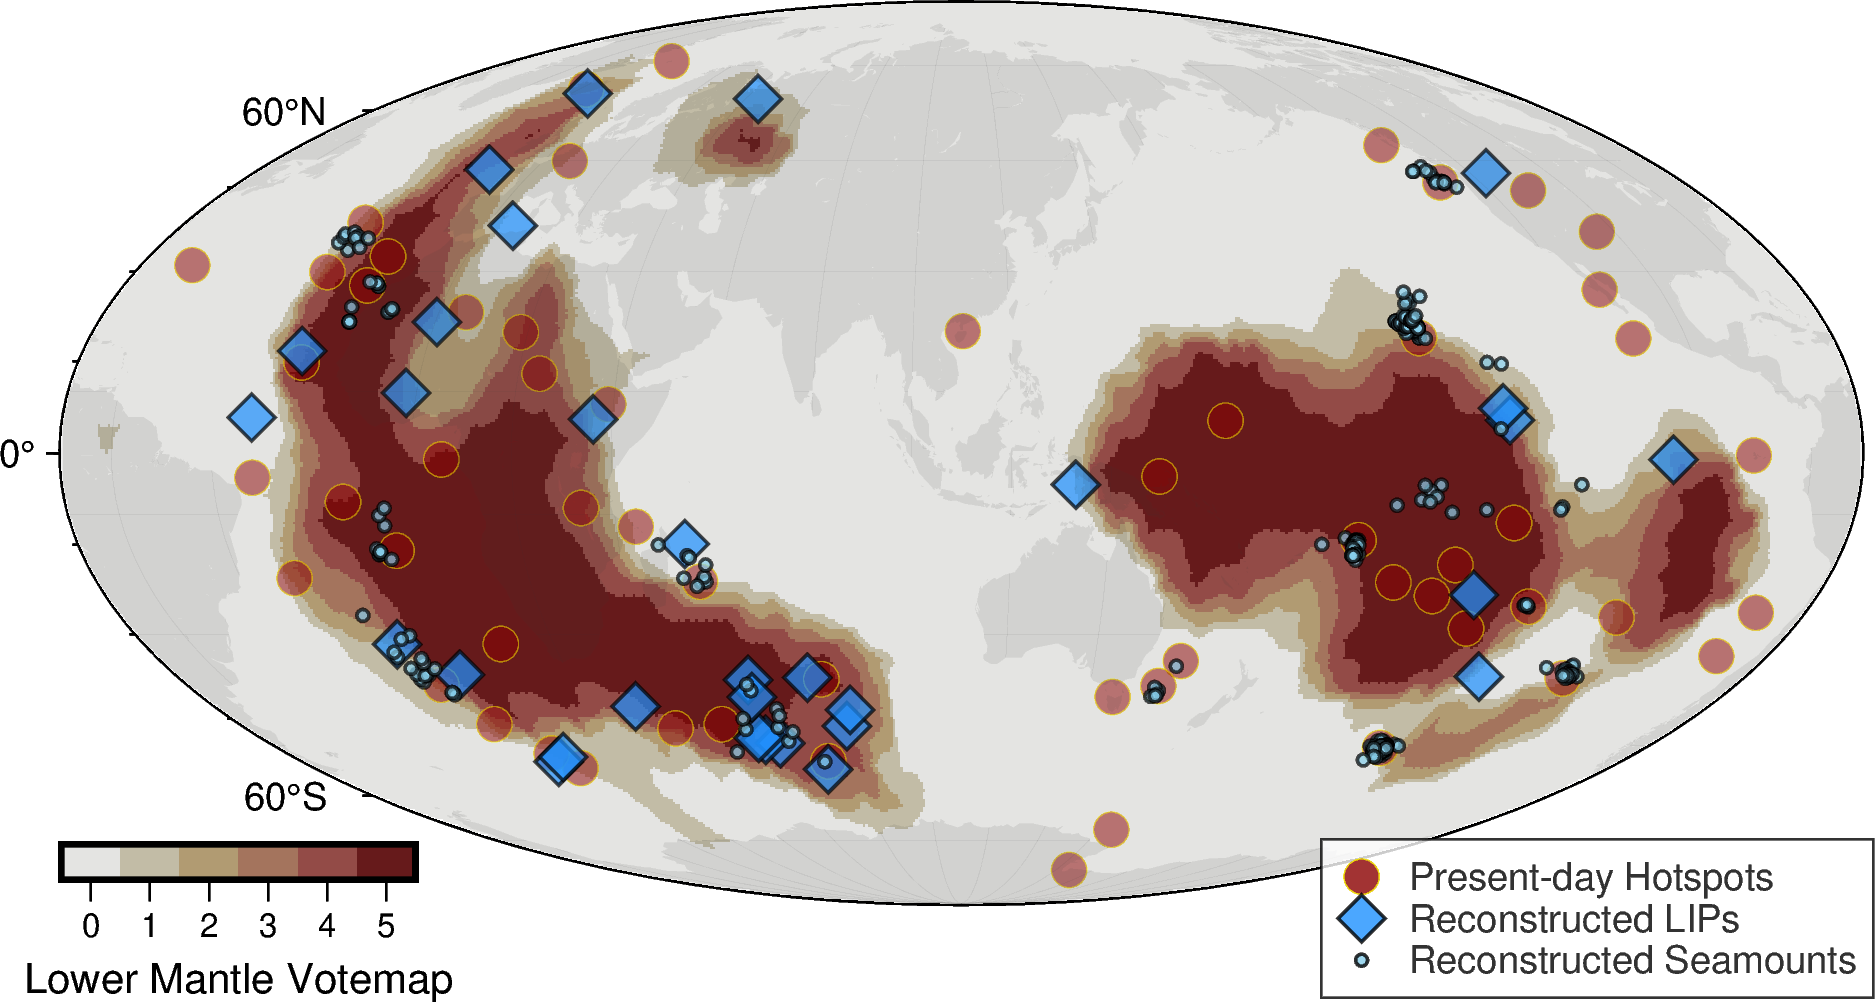

In [19]:
TC2017 = Reconstructions.fetch_TorsvikCocks2017()

LIP_centroids2 = pygplates.FeatureCollection('./data/Doubrovine-et-al-2016.gpml')
LIP_centroids3 = pygplates.FeatureCollection('./data/CEED6_LIPCentersAround5Ma.gpml')
trails = gpd.read_file('./HotspotTrails.geojson')
trails = trails[trails.Chain.isin(['Hawaii','Louisville','Reunion','Tasmantid','Lord_Howe','Kerguelen',
                                   'Tristan','Canary','St_Helena','New_England','Tuamoto','Samoa',
                                   'Cobb','Foundation','Musicians','Marcus-Wake','Mid_Pacific_Mountains','Pitcairn','Shatsky'])]
trails = gdf2gpml(trails)
kimberlites = pygplates.FeatureCollection('/Users/simon/Data/zenodo/Assembly_African_basal_mantle_structure_supplement/Volcanic_eruption_locations/M21/T18/T18_centroids_M21_plateIDs.gpml')
kimberlites = TC2017.assign_plate_ids(kimberlites)


reconstruction_time = 180.

fig = pygmt.Figure()
fig.basemap(region='d', projection='W110/6i', frame='afg')

lekic_filt = pygmt.grdfilter(grid='/Users/simon/Work/DynamicTopography/Clustering_Lekic.nc', distance=2, filter='g800', spacing='0.5d')
pygmt.makecpt(cmap='bilbao', series=[-0.5,5.5,1], background=False) #, color_model="+c" + ",".join(['0','1','2','3','4','5']))
fig.grdimage(grid=lekic_filt.astype(int), cmap=True, transparency=0, interpolation='l')

#TC2017.polygon_snapshot('coastlines', reconstruction_time).plot(fig, transparency=75, pen='0p,gray', color='darkkhaki')

fig.plot(x=HS['Hotspot Longitude (at surface) Vertical plume'].astype(float),
         y=HS['Hotspot Latitude (at surface) Vertical plume'].astype(float), 
         style='c0.3c', pen='0.2p,yellow', color='darkred', transparency=50, label='Present-day Hotspots')

#fig.plot(data=gpml2gdf(reconstructed_centroids), style='d0.3c', pen='0.7p,black', color='orange', transparency=30)
rLIPs = TC2017.reconstruct_to_time_of_appearance(LIP_centroids)
#rLIPs = M2016.reconstruct_to_time_of_appearance(LIP_centroids)
rLIPs2 = TC2017.reconstruct_to_time_of_appearance(LIP_centroids2)
rLIPs3 = TC2017.reconstruct_to_time_of_appearance(LIP_centroids3, ReconstructTime='MidTime')
rtrails = TC2017.reconstruct_to_time_of_appearance(trails)
rkimberlites = TC2017.reconstruct_to_time_of_appearance(kimberlites)

#fig.plot(data=gpml2gdf(LIP_centroids2), style='d0.3c', pen='0.7p,black', color='orange', transparency=80)
#fig.plot(data=gpml2gdf(rLIPs), style='d0.3c', pen='0.7p,black', color='blue', transparency=30)
fig.plot(data=gpml2gdf(rLIPs3), style='d0.4c', pen='0.7p,black', color='dodgerblue', transparency=30, label='Reconstructed LIPs')

fig.plot(data=gpml2gdf(rtrails), style='c0.1c', pen='0.7p,black', color='skyblue', transparency=30, label='Reconstructed Seamounts')
#fig.plot(data=gpml2gdf(trails), style='d0.1c', pen='0.7p,black', color='blue', transparency=90)

#tmp = gpml2gdf(rkimberlites)
#tmp = tmp[tmp.FROMAGE<=200.]
#fig.plot(data=tmp, style='d0.1c', pen='0.7p,black', color='pink', transparency=30)


fig.coast(land='gray20', transparency=90)
fig.legend(transparency=20, position='JBR+jBR+o-0.1c/-0.8c', box='+gwhite+p0.5p')
with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='10p'):
    fig.colorbar(position='JBL+jBL+o0.0c/0.2c+w3c/0.3c+h', frame=['xa1+lLower Mantle Votemap'])
#fig.coast(shorelines='gray20', transparency=60)

fig.savefig('./figures/plume_generation_zone.pdf')
fig.show(width=1000)



In [196]:
hslist = ['Hawaii','Louisville','Reunion','Tasmantid','Howe','Kerguelen',
                                   'Tristan','Canary','St_Helena','New_England','Tuamoto','Samoa','Pitcairn'
                                   'Cobb','Foundation'] #'Musicians','Marcus-Wake','Mid_Pacific_Mountains','Shatsky'])]
HSsel = HS[HS['Hotspota'].str.contains('|'.join(hslist))]


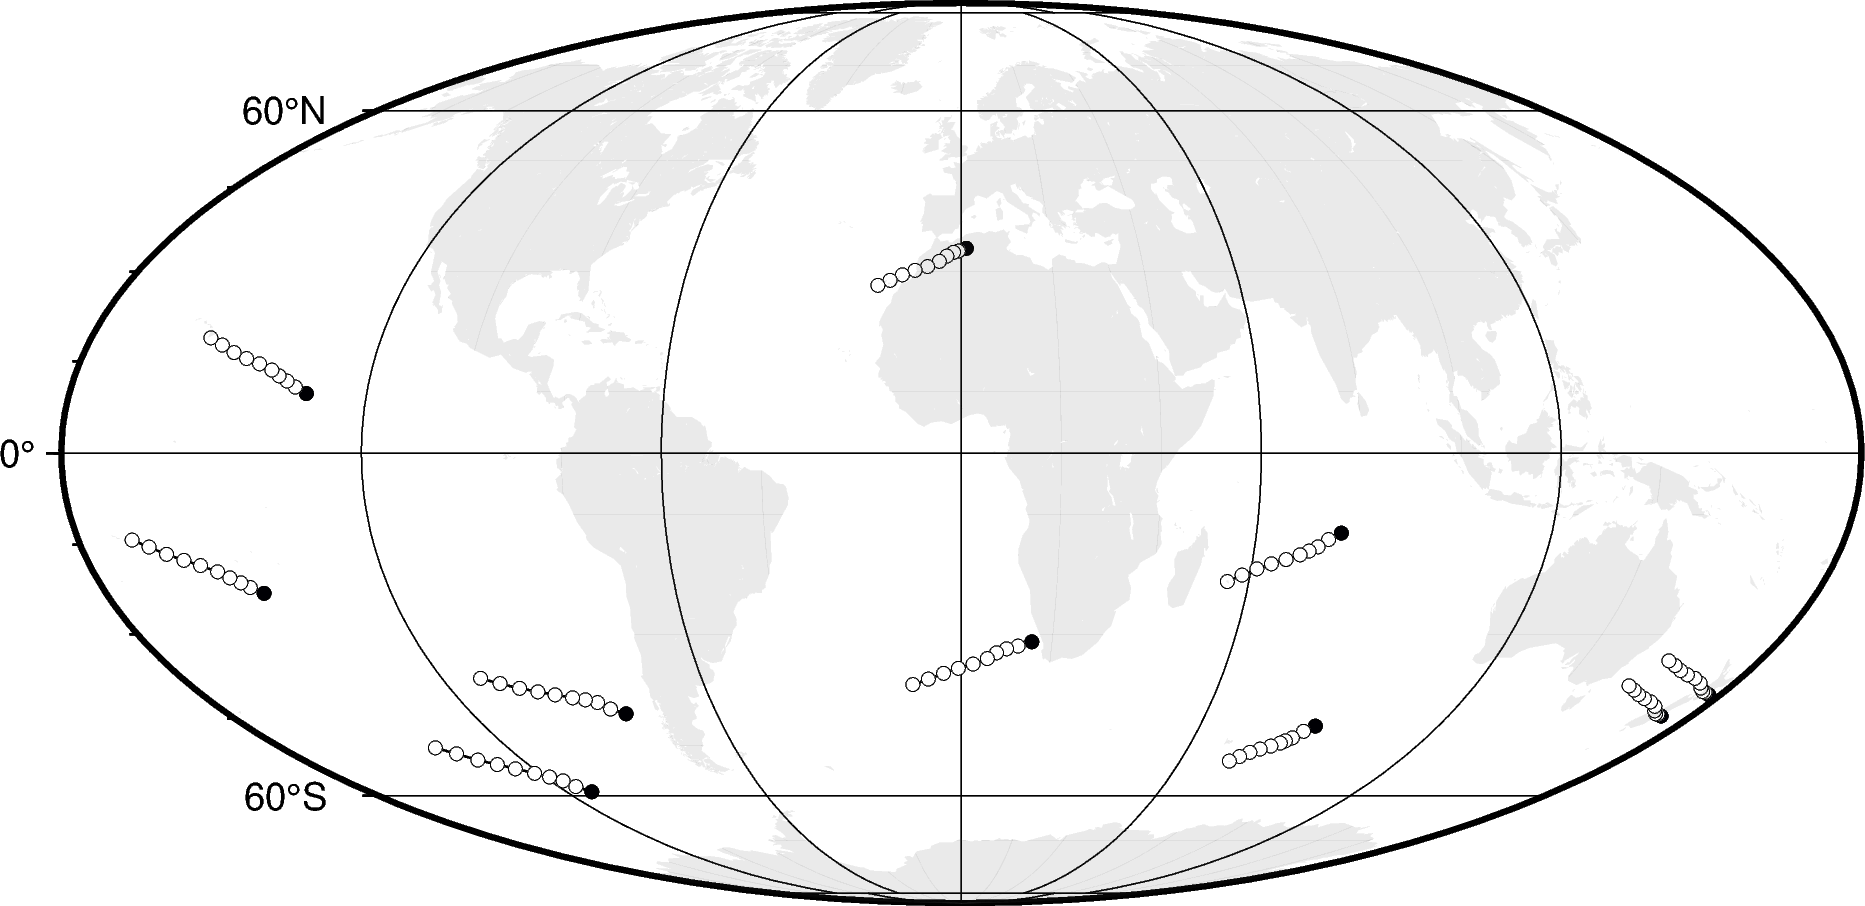

In [202]:
from gprm import MotionPathFeature
path_times = np.arange(0,50,5)

fig = pygmt.Figure()
fig.basemap(region='d', projection='W6i', frame='afg')

for i,row in HSsel.iterrows():
    if HSsel['Hotspota'].str.contains(['Tasmantid', 'Howe']):
        plateid==801
    elif HSsel['Hotspota'].str.contains(['Reunion', 'Tristan', 'Canary', 'St_Helena']):
    Trails = MotionPathFeature(path_times=path_times, 
                      seed_points=(row['Hotspot Latitude (at surface) Vertical plume'], row['Hotspot Longitude (at surface) Vertical plume']),
                      reconstruction_plate_id=901, 
                      relative_plate_id=0).reconstruct_motion_path(M2019)[0]
    fig.plot(x=Trails[:,1], y=Trails[:,0], pen='0.5p,black')
    fig.plot(x=Trails[:,1], y=Trails[:,0], style='c0.12c', pen='0.1p,black', 
                     color=path_times, cmap='magma')
    
fig.coast(land='gray20', transparency=90)
#fig.coast(shorelines='gray20', transparency=60)
fig.show(width=1000)